In [ ]:
!pip install mitsuba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 38.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import mitsuba as mi
import drjit as dr
import matplotlib.pyplot as plt
import tempfile, io, os

mi.set_variant("cuda_ad_rgb")

# ============================================================
# Physical constants
# ============================================================
c0   = 299792458.0
freq = 1e9
lam  = c0 / freq
k0   = 2*np.pi / lam
eta0 = 376.730313668

# ============================================================
# Geometry: arbitrary PEC object (example: square plate)
# ============================================================
L, W = 6.0, 4.0

verts = np.array([
    [-L/2, -W/2, 0.0],
    [ L/2, -W/2, 0.0],
    [ L/2,  W/2, 0.0],
    [-L/2,  W/2, 0.0]
], np.float32)

faces = np.array([[0,1,2],[0,2,3]], np.int32)

def write_ply(v, f):
    s = io.StringIO()
    s.write("ply\nformat ascii 1.0\n")
    s.write(f"element vertex {len(v)}\n")
    s.write("property float x\nproperty float y\nproperty float z\n")
    s.write(f"element face {len(f)}\n")
    s.write("property list uchar int vertex_index\nend_header\n")
    for x in v: s.write(f"{x[0]} {x[1]} {x[2]}\n")
    for t in f: s.write(f"3 {t[0]} {t[1]} {t[2]}\n")
    return s.getvalue()

with tempfile.NamedTemporaryFile(delete=False,suffix=".ply",mode="w") as f:
    f.write(write_ply(verts,faces))
    plyfile = f.name

scene = mi.load_dict({
    "type":"scene",
    "object":{
        "type":"ply",
        "filename":plyfile,
        "face_normals":True
    }
})

# ============================================================
# Utilities
# ============================================================
def transverse_pol(k):
    ref = np.array([0,0,1])
    if abs(np.dot(ref,k)) > 0.9:
        ref = np.array([0,1,0])
    e = np.cross(k,ref)
    return e / np.linalg.norm(e)

def orthonormal_basis(k):
    tmp = np.array([0,0,1])
    if abs(np.dot(tmp,k)) > 0.9:
        tmp = np.array([0,1,0])
    u = np.cross(k,tmp); u /= np.linalg.norm(u)
    v = np.cross(k,u)
    return u, v

# ============================================================
# 1. Plane-wave ray generation (SBR illumination)
# ============================================================
def generate_plane_wave_rays(k_hat, extent, N):
    """
    k_hat   : incident direction (unit)
    extent : half-size of wavefront plane
    N      : samples per dimension
    """

    u_hat, v_hat = orthonormal_basis(k_hat)

    # launch plane center
    plane_center = -5*lam * k_hat

    x = np.linspace(-extent, extent, N)
    y = np.linspace(-extent, extent, N)
    X, Y = np.meshgrid(x, y, indexing="ij")

    origins = (
        plane_center[None,None,:]
        + X[...,None]*u_hat
        + Y[...,None]*v_hat
    ).reshape(-1,3)

    dirs = np.repeat(k_hat[None,:], origins.shape[0], axis=0)

    dS = (2*extent/(N-1))**2

    return origins, dirs, dS

# ============================================================
# 2. Surface interaction model (IPO-ready)
# ============================================================
def surface_current_PEC(P, N, k_hat, E0):
    """
    PEC Physical Optics surface current
    """
    H0 = np.cross(k_hat, E0) / eta0
    phase = np.exp(-1j*k0*(P @ k_hat))
    Js = 2*np.cross(N, H0) * phase[:,None]
    return Js

# Placeholder for future IPO:
# def surface_current_IPO(...):
#     Zs = ...
#     Js = (2/(1+Zs/eta0)) * np.cross(N, H0)

# ============================================================
# 3. Far-field integration
# ============================================================
def far_field_PO(P, N, Js, k_hat, r_hat, dS_launch):
    """
    Correct SBR-PO far-field integration.

    Parameters:
    - P: Hit points on surface (N_hit, 3)
    - N: Surface normals (N_hit, 3)
    - Js: Surface currents (N_hit, 3)
    - k_hat: Incident direction (3,)
    - r_hat: Observation direction (3,)
    - dS_launch: Area element on launching plane
    """

    # Jacobian: surface area element = launching plane area element / |k·n|
    cos_theta = np.abs(np.sum(N * k_hat[None, :], axis=1))
    cos_theta = np.maximum(cos_theta, 1e-6)  # Avoid division by zero

    # Area element on surface
    dS_surface = dS_launch / cos_theta

    # Phase term for scattering
    phase = np.exp(1j * k0 * np.einsum('ij,j->i', P, r_hat))

    # Radiation integrand
    integrand = np.cross(r_hat, np.cross(r_hat, Js))

    # Weight by surface area element and phase
    weighted_integrand = integrand * phase[:, None] * dS_surface[:, None]

    # Far-field scattering
    E_scat = (1j * k0 * eta0 / (4 * np.pi)) * np.sum(weighted_integrand, axis=0)

    return E_scat


# ============================================================
# 4. Full SBR-IPO solver (single bounce)
# ============================================================
def sbr_ipo_rcs(theta, phi, extent=4.0, N=1200):

    # --------------------------------------------------------
    # Incident and observation directions (monostatic)
    # --------------------------------------------------------
    k_hat = np.array([
        np.sin(theta)*np.cos(phi),
        np.sin(theta)*np.sin(phi),
       -np.cos(theta)
    ])

    r_hat = -k_hat

    E0 = transverse_pol(k_hat)

    # --------------------------------------------------------
    # Ray generation (geometry-independent)
    # --------------------------------------------------------
    origins, dirs, dS = generate_plane_wave_rays(
        k_hat, extent, N
    )

    # --------------------------------------------------------
    # Mitsuba ray batch
    # --------------------------------------------------------
    rays = mi.Ray3f(
        mi.Point3f(mi.Float(origins[:,0]),
                   mi.Float(origins[:,1]),
                   mi.Float(origins[:,2])),
        mi.Vector3f(mi.Float(dirs[:,0]),
                    mi.Float(dirs[:,1]),
                    mi.Float(dirs[:,2]))
    )

    its = scene.ray_intersect(rays)
    mask = its.is_valid()

    if not dr.any(mask):
        return -300.0

    P = np.column_stack([
        np.array(its.p.x),
        np.array(its.p.y),
        np.array(its.p.z)
    ])[np.array(mask)]

    N = np.column_stack([
        np.array(its.n.x),
        np.array(its.n.y),
        np.array(its.n.z)
    ])[np.array(mask)]

    # --------------------------------------------------------
    # Surface currents (PEC now, IPO later)
    # --------------------------------------------------------
    Js = surface_current_PEC(P, N, k_hat, E0)

    # --------------------------------------------------------
    # Far-field
    # --------------------------------------------------------
    Escat = far_field_PO(P, N, Js, k_hat, r_hat, dS)

    sigma = 4*np.pi*np.linalg.norm(Escat)**2
    return 10*np.log10(sigma + 1e-30)

os.unlink(plyfile)


In [ ]:
# ============================================================
# Analytic PO RCS for rectangular PEC plate
# ============================================================
def analytic_po_rcs(theta, phi, L, W, lam):
    """
    Analytic Physical Optics monostatic RCS of rectangular PEC plate
    """

    k = 2*np.pi / lam

    u = k * L * np.sin(theta) * np.cos(phi)
    v = k * W * np.sin(theta) * np.sin(phi)

    def sinc(x):
        return np.where(np.abs(x) < 1e-12, 1.0, np.sin(x)/x)

    sigma = (
        4*np.pi / lam**2
        * (L*W*np.cos(theta))**2
        * sinc(u)**2
        * sinc(v)**2
    )

    return 10*np.log10(sigma + 1e-30)

In [ ]:
def sweep_theta(theta_list, phi_fixed, extent=4.0, N=1200):
    """
    Monostatic RCS vs theta at fixed phi
    """
    RCS = np.zeros(len(theta_list))

    print(f"Sweeping theta, fixed phi = {np.rad2deg(phi_fixed):.1f}°")
    for i, theta in enumerate(theta_list):
        RCS[i] = sbr_ipo_rcs(theta, phi_fixed, extent, N)

    return RCS


/tmp/ipython-input-4149685456.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.where(np.abs(x) < 1e-12, 1.0, np.sin(x)/x)


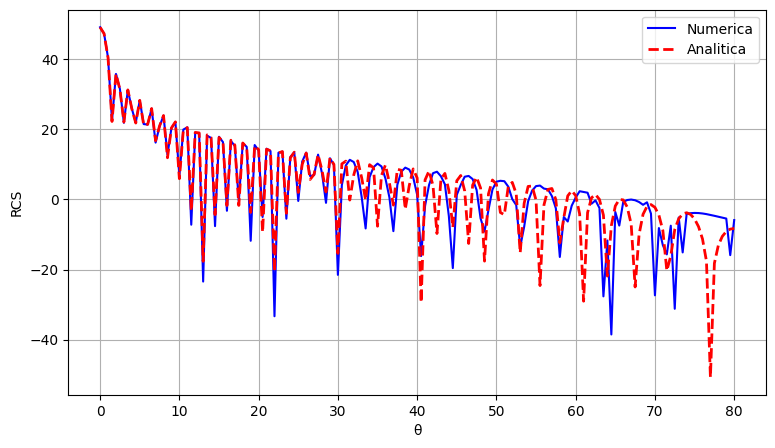

In [ ]:
# ============================================================
# θ-cut comparison
# ============================================================
phi = np.deg2rad(0.0)
thetas = np.deg2rad(np.linspace(0,80,161))

rcs_num = np.array([sbr_ipo_rcs(t,phi,extent=6.0) for t in thetas])
rcs_ana = np.array([analytic_po_rcs(t,phi,L,W,lam) for t in thetas])

plt.figure(figsize=(9,5))
plt.plot(np.rad2deg(thetas), rcs_num, 'b', label="SBR–IPO (numeric)")
plt.plot(np.rad2deg(thetas), rcs_ana, 'r--', lw=2, label="Analytic PO")
plt.xlabel("θ [deg]")
plt.ylabel("RCS [dBsm]")
plt.title("Monostatic RCS – θ cut (φ = 0°)")
plt.grid(True)
plt.legend()
plt.show()



In [ ]:
def sweep_phi(phi_list, theta_fixed, extent=4.0, N=1200):
    """
    Monostatic RCS vs phi at fixed theta
    """
    RCS = np.zeros(len(phi_list))

    print(f"Sweeping phi, fixed theta = {np.rad2deg(theta_fixed):.1f}°")
    for i, phi in enumerate(phi_list):
        RCS[i] = sbr_ipo_rcs(theta_fixed, phi, extent, N)

    return RCS


/tmp/ipython-input-4149685456.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return np.where(np.abs(x) < 1e-12, 1.0, np.sin(x)/x)


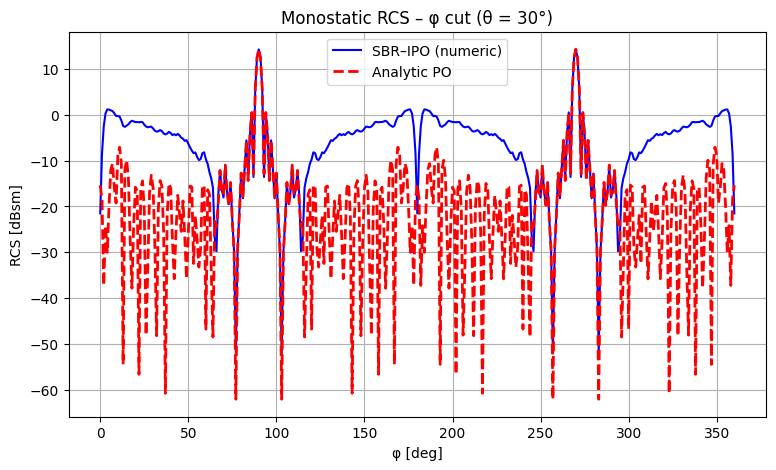

In [ ]:
# ============================================================
# φ-cut comparison
# ============================================================
theta = np.deg2rad(30)
phis  = np.deg2rad(np.linspace(0,360,361))

rcs_num = np.array([sbr_ipo_rcs(theta,p,extent=6.0) for p in phis])
rcs_ana = np.array([analytic_po_rcs(theta,p,L,W,lam) for p in phis])

plt.figure(figsize=(9,5))
plt.plot(np.rad2deg(phis), rcs_num, 'b', label="SBR–IPO (numeric)")
plt.plot(np.rad2deg(phis), rcs_ana, 'r--', lw=2, label="Analytic PO")
plt.xlabel("φ [deg]")
plt.ylabel("RCS [dBsm]")
plt.title(f"Monostatic RCS – φ cut (θ = {np.rad2deg(theta):.0f}°)")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
def sweep_theta_phi(theta_list, phi_list, extent=4.0, N=1200):
    """
    Full monostatic RCS(theta, phi)
    Returns RCS[it, ip]
    """
    RCS = np.zeros((len(theta_list), len(phi_list)))

    for it, theta in enumerate(theta_list):
        print(f"Theta {np.rad2deg(theta):5.1f}° ({it+1}/{len(theta_list)})")
        for ip, phi in enumerate(phi_list):
            RCS[it, ip] = sbr_ipo_rcs(theta, phi, extent, N)

    return RCS


In [ ]:
theta_list = np.deg2rad(np.linspace(0, 80, 81))
phi_list   = np.deg2rad(np.linspace(0, 360, 181))

RCS_map = sweep_theta_phi(theta_list, phi_list, extent=6.0)

plt.figure(figsize=(9,6))
plt.imshow(
    RCS_map,
    extent=[0, 360, theta_list[-1]*180/np.pi, theta_list[0]*180/np.pi],
    aspect="auto",
    cmap="viridis"
)
plt.colorbar(label="RCS [dBsm]")
plt.xlabel("φ [deg]")
plt.ylabel("θ [deg]")
plt.title("Monostatic RCS(θ, φ) — SBR-IPO (PEC)")
plt.show()


Theta   0.0° (1/81)
Theta   1.0° (2/81)
Theta   2.0° (3/81)
Theta   3.0° (4/81)
Theta   4.0° (5/81)
Theta   5.0° (6/81)
Theta   6.0° (7/81)
Theta   7.0° (8/81)
Theta   8.0° (9/81)
Theta   9.0° (10/81)
Theta  10.0° (11/81)
Theta  11.0° (12/81)
Theta  12.0° (13/81)
Theta  13.0° (14/81)
Theta  14.0° (15/81)
